In [2]:
%matplotlib inline

import nltk
from nltk.stem.snowball import SnowballStemmer
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import json
from textblob import TextBlob
from sklearn.cross_validation import cross_val_score
import metrics
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
import text_processors
from progressbar import ProgressBar

plt.rcParams["figure.figsize"] = (10, 8)

stopwords = set(nltk.corpus.stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [3]:
def contest_metric(numpy_array_predictions, numpy_array_actual_values):
    return metrics.weighted_rmsle(numpy_array_predictions, numpy_array_actual_values,
            weights=metrics.KEEPING_IT_CLEAN_WEIGHTS)

In [4]:
def contest_scoring(X, y, pipeline):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    s1 = pipeline.fit(X_train, y_train['score_lvl_1']).predict(X_test)
    s2 = pipeline.fit(X_train, y_train['score_lvl_2']).predict(X_test)
    s3 = pipeline.fit(X_train, y_train['score_lvl_3']).predict(X_test)
    results = np.dstack((s1, s2, s3))
    score = contest_metric(np.round(results[0]), np.array(y_test))
    print("Contest score of {}".format(score))
    return score

In [5]:
def score_model(X, y, pipeline):
    scores = cross_val_score(pipeline, X, y, cv=3, n_jobs=1, verbose=1)
    mean_score = np.mean(scores)
    std_dev_score = np.std(scores)
    print("CV score of {} +/- {}".format(mean_score, std_dev_score))

In [6]:
def extract_features(df):
    features = df.drop(['score_lvl_1', 'score_lvl_2', 'score_lvl_3'], axis=1)
    response = df[['score_lvl_1', 'score_lvl_2', 'score_lvl_3']].astype(np.float64)  #for numerical progression
    # response = df[['score_lvl_1', 'score_lvl_2', 'score_lvl_3']].astype(np.int8)  # for categorical response
    return features, response

In [7]:
import data_grab
train_df, test_df = data_grab.get_flats()

In [8]:
tdmax = train_df.review_delta.max()
tdmin = train_df.review_delta.min()
train_df['review_delta_bin'] = pd.cut(train_df["review_delta"], np.arange(tdmin, tdmax, 30))

In [9]:
X, y = extract_features(train_df)

In [10]:
data = pd.concat([X, y], axis=1)
scores = y[['score_lvl_1', 'score_lvl_2', 'score_lvl_3']]
transformed_y = pd.DataFrame(scores.multiply([1, 3, 5], axis=1).sum(axis=1), columns=['transformed_score'])
data['transformed_score'] = transformed_y

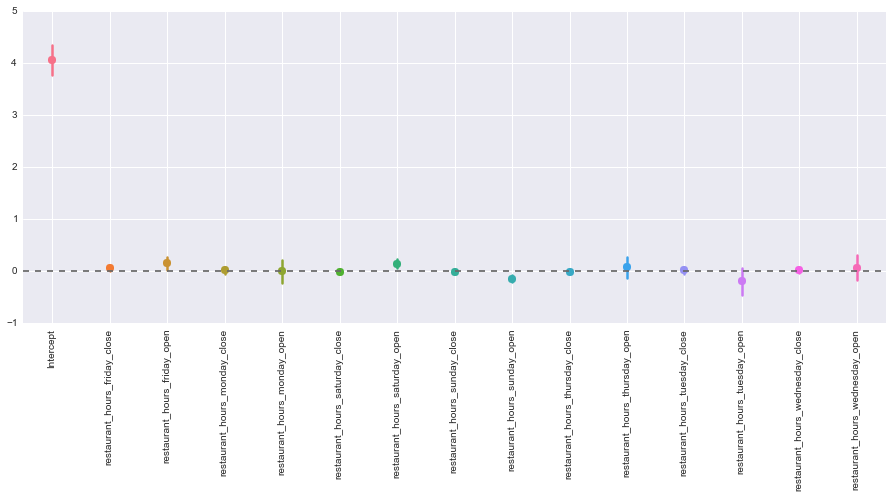

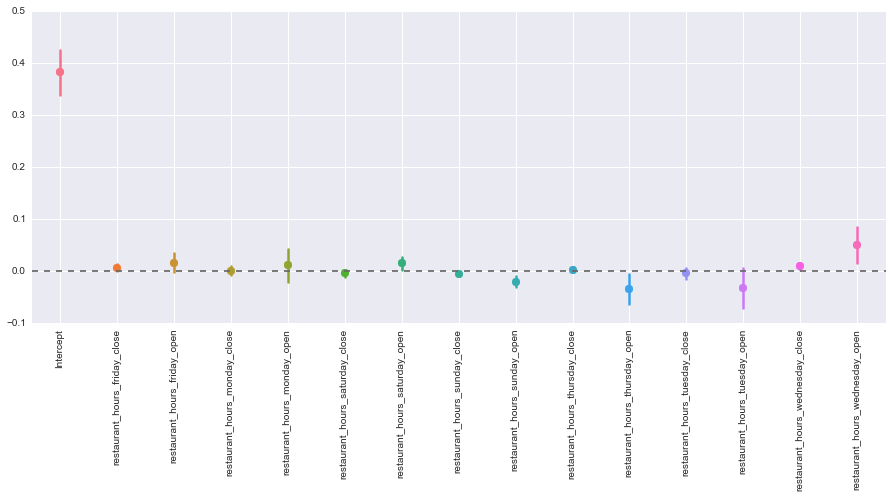

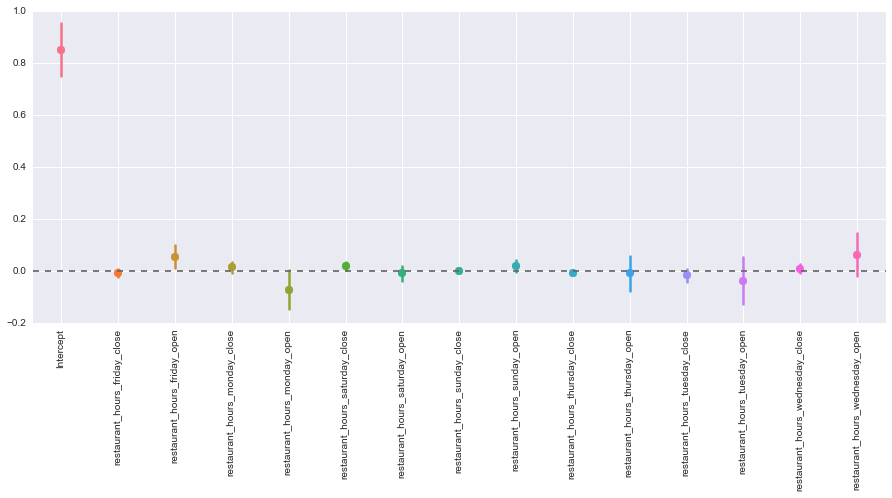

In [24]:
hours = X[['restaurant_hours_friday_close',
 'restaurant_hours_friday_open',
 'restaurant_hours_monday_close',
 'restaurant_hours_monday_open',
 'restaurant_hours_saturday_close',
 'restaurant_hours_saturday_open',
 'restaurant_hours_sunday_close',
 'restaurant_hours_sunday_open',
 'restaurant_hours_thursday_close',
 'restaurant_hours_thursday_open',
 'restaurant_hours_tuesday_close',
 'restaurant_hours_tuesday_open',
 'restaurant_hours_wednesday_close',
 'restaurant_hours_wednesday_open',]]
# sns.mpl.rc("figure", figsize=(60,10))
sns.mpl.rc("figure", figsize=(10,14))
# X_formula = " + ".join(['C({})'.format(i) for i in hours.columns.tolist()])
X_formula = " + ".join(['{}'.format(i) for i in hours.columns.tolist()])

scores = ['score_lvl_1', 'score_lvl_2', 'score_lvl_3']
for score in scores:
    formula = score + " ~ " + X_formula
    print("\n* Formula: {}".format(formula))

    # seaborn can't handle categorical data type so have to convert_objects first
    g = sns.coefplot(formula, data.convert_objects(), intercept=True)
    plt.xticks(rotation=90)
    plt.tight_layout()
#     plt.savefig('visuals/categorical_opening_closing_hours_coefficients_' + score)
    plt.savefig('visuals/opening_closing_hours_coefficients_' + score)


sns.mpl.rc("figure", figsize=(14,10))

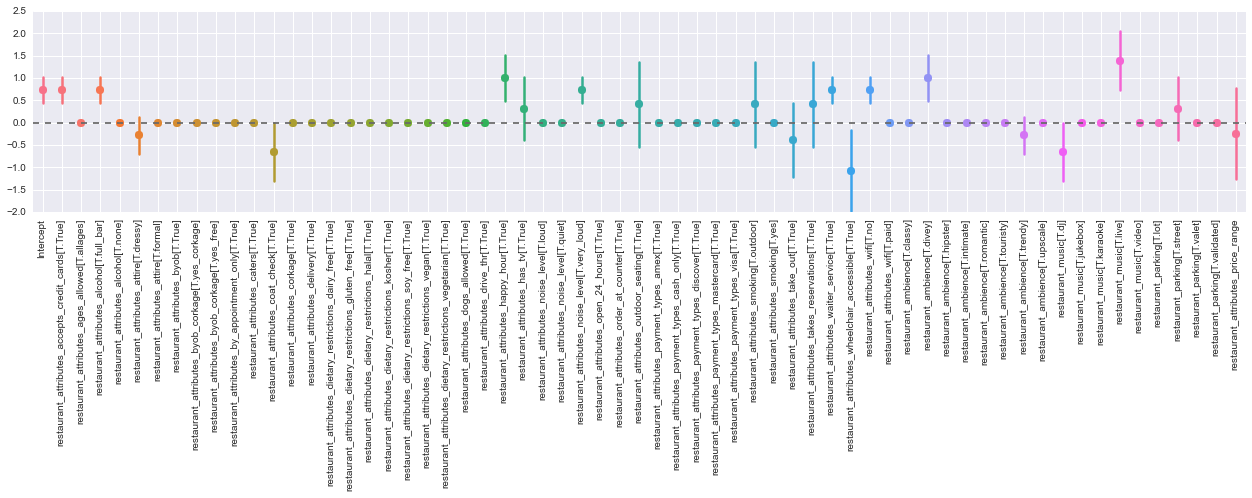

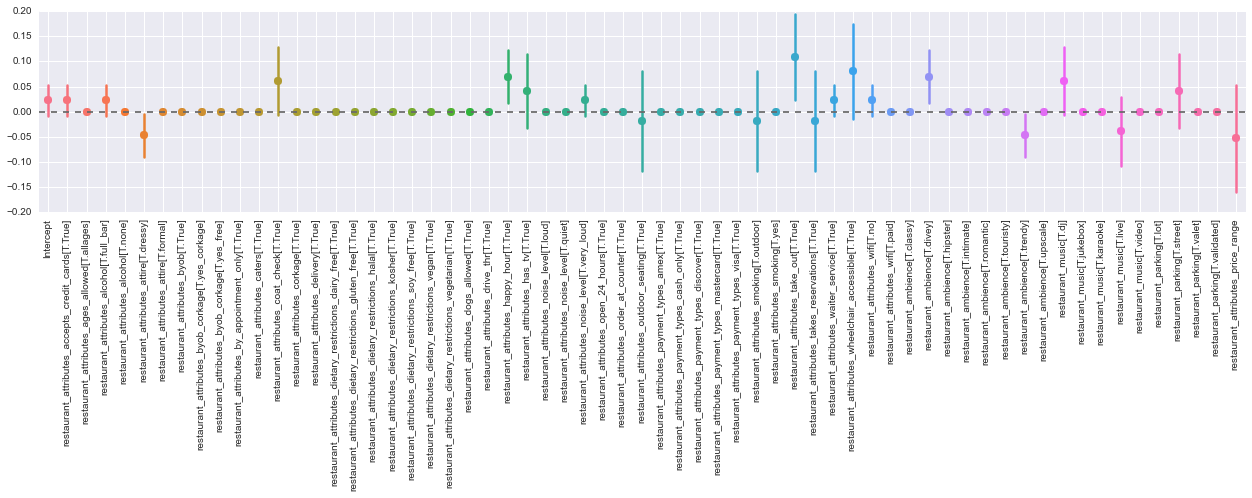

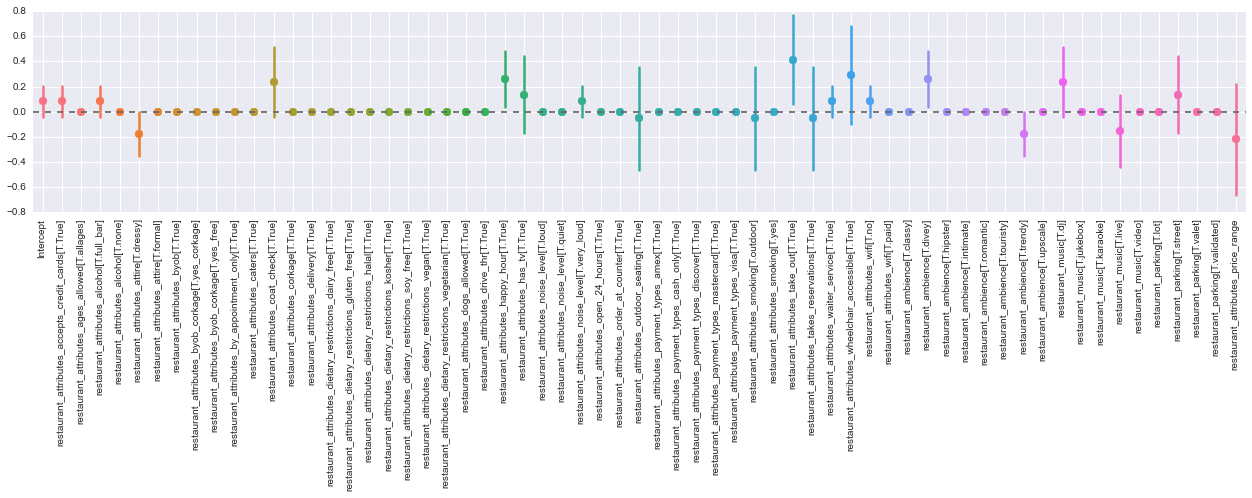

In [20]:
atts = X[[
        'restaurant_attributes_accepts_credit_cards',
 'restaurant_attributes_ages_allowed',
 'restaurant_attributes_alcohol',
 'restaurant_attributes_attire',
 'restaurant_attributes_byob',
 'restaurant_attributes_byob_corkage',
 'restaurant_attributes_by_appointment_only',
 'restaurant_attributes_caters',
 'restaurant_attributes_coat_check',
 'restaurant_attributes_corkage',
 'restaurant_attributes_delivery',
 'restaurant_attributes_dietary_restrictions_dairy_free',
 'restaurant_attributes_dietary_restrictions_gluten_free',
 'restaurant_attributes_dietary_restrictions_halal',
 'restaurant_attributes_dietary_restrictions_kosher',
 'restaurant_attributes_dietary_restrictions_soy_free',
 'restaurant_attributes_dietary_restrictions_vegan',
 'restaurant_attributes_dietary_restrictions_vegetarian',
 'restaurant_attributes_dogs_allowed',
 'restaurant_attributes_drive_thr',
#  'restaurant_attributes_good_for_dancing',
#  'restaurant_attributes_good_for_groups',
#  'restaurant_attributes_good_for_breakfast',
#  'restaurant_attributes_good_for_brunch',
#  'restaurant_attributes_good_for_dessert',
#  'restaurant_attributes_good_for_dinner',
#  'restaurant_attributes_good_for_latenight',
#  'restaurant_attributes_good_for_lunch',
#  'restaurant_attributes_good_for_kids',
 'restaurant_attributes_happy_hour',
 'restaurant_attributes_has_tv',
 'restaurant_attributes_noise_level',
 'restaurant_attributes_open_24_hours',
 'restaurant_attributes_order_at_counter',
 'restaurant_attributes_outdoor_seating',
 'restaurant_attributes_payment_types_amex',
 'restaurant_attributes_payment_types_cash_only',
 'restaurant_attributes_payment_types_discover',
 'restaurant_attributes_payment_types_mastercard',
 'restaurant_attributes_payment_types_visa',
 'restaurant_attributes_price_range',
 'restaurant_attributes_smoking',
 'restaurant_attributes_take_out',
 'restaurant_attributes_takes_reservations',
 'restaurant_attributes_waiter_service',
 'restaurant_attributes_wheelchair_accessible',
 'restaurant_attributes_wifi',
 'restaurant_ambience',
 'restaurant_music',
 'restaurant_parking'
         ]]
sns.mpl.rc("figure", figsize=(14,14))
X_formula = " + ".join([i for i in atts.columns.tolist()])

scores = ['score_lvl_1', 'score_lvl_2', 'score_lvl_3']
for score in scores:
    formula = score + " ~ " + X_formula
    print("\n* Formula: {}".format(formula))

    # seaborn can't handle categorical data type so have to convert_objects first
    g = sns.coefplot(formula, data.convert_objects(), intercept=True)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('visuals/restaurant_attributes_coefficients_' + score)

sns.mpl.rc("figure", figsize=(14,10))

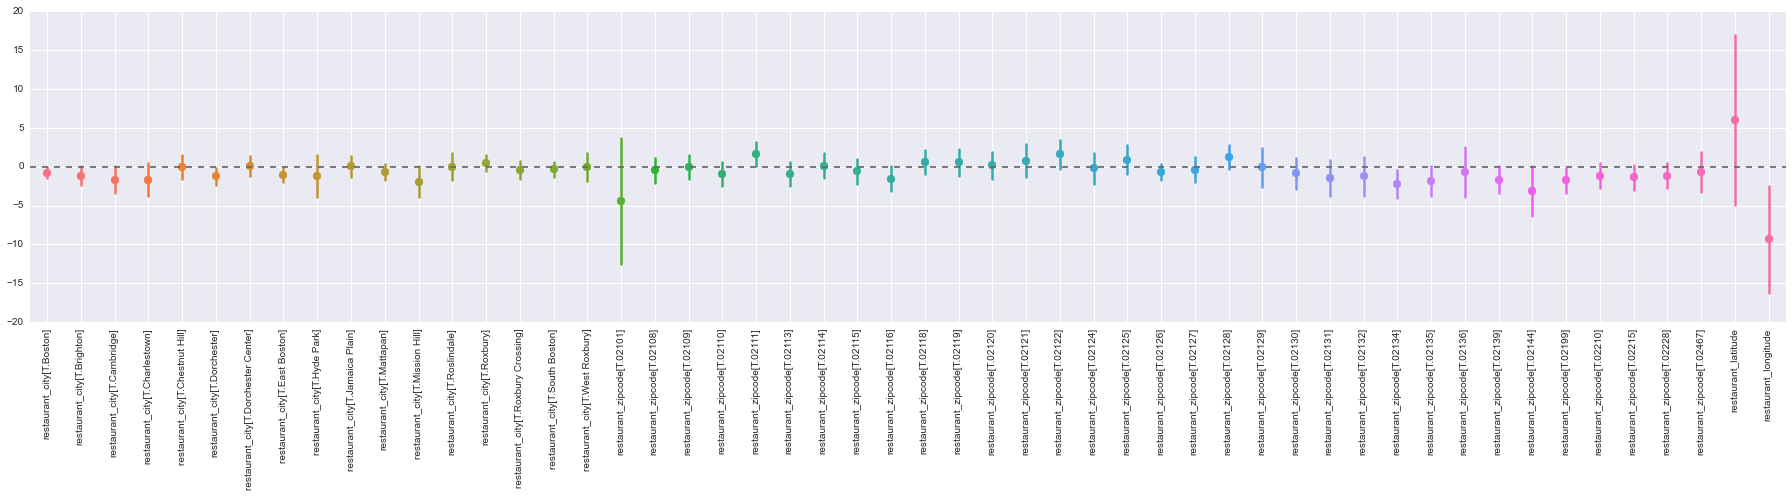

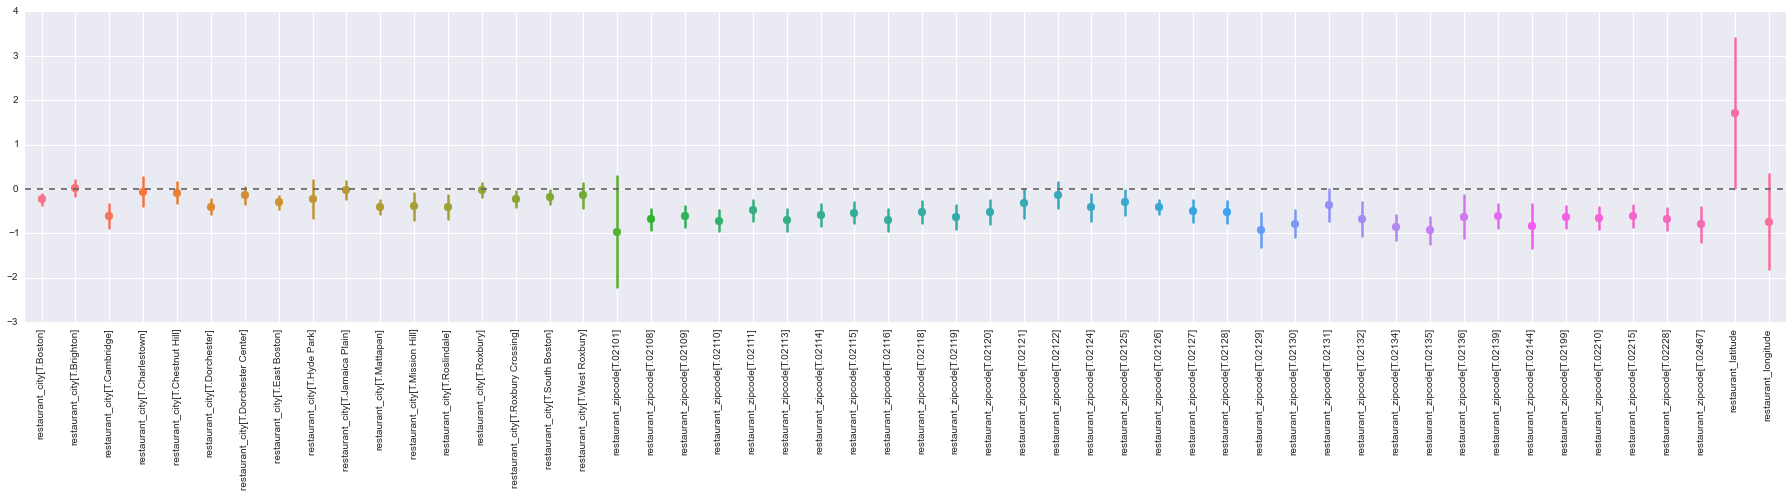

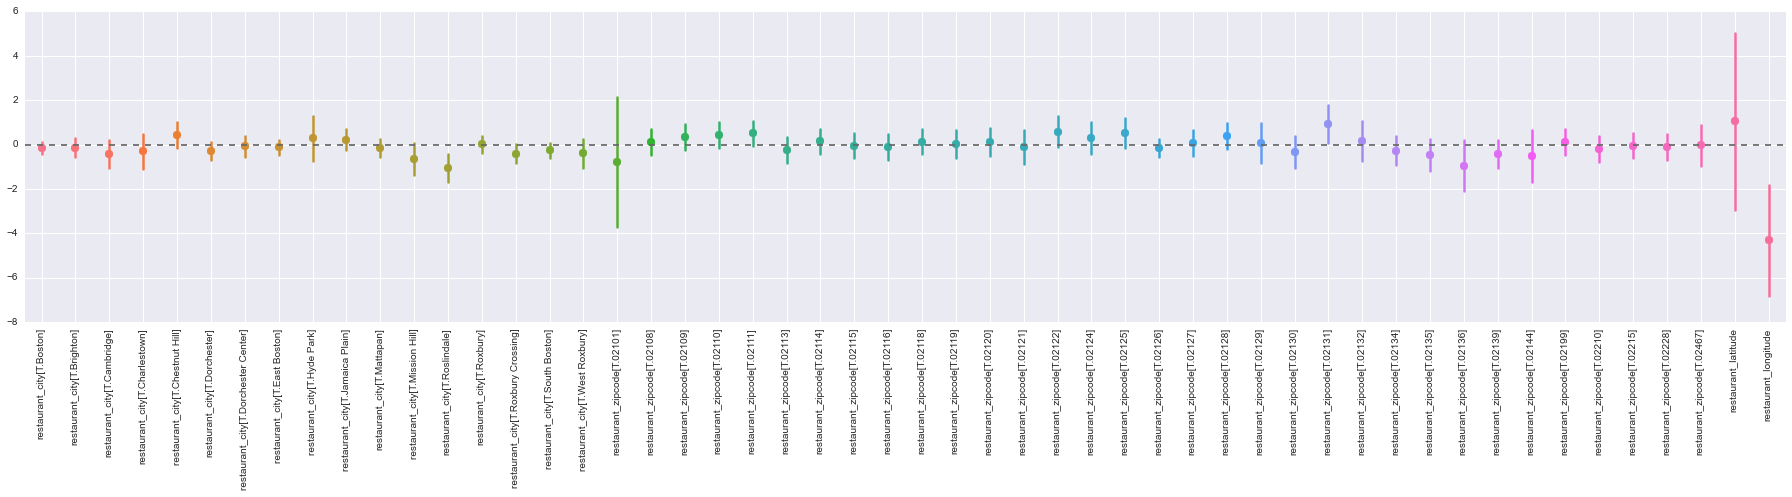

In [26]:
location_attributes = X[[
    'restaurant_city', 'restaurant_latitude',
    'restaurant_longitude', 
#     'restaurant_street',
    'restaurant_zipcode',
]]
sns.mpl.rc("figure", figsize=(20,14))
X_formula = " + ".join([i for i in location_attributes.columns.tolist()])

scores = ['score_lvl_1', 'score_lvl_2', 'score_lvl_3']
for score in scores:
    formula = score + " ~ " + X_formula
#     formula = score + " ~ restaurant_city + restaurant_latitude + restaurant_longitude + C(restaurant_zipcode)"
    print("\n* Formula: {}".format(formula))

    # seaborn can't handle categorical data type so have to convert_objects first
    g = sns.coefplot(formula, data.convert_objects(), intercept=False)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('visuals/location_attributes_coefficients_' + score)

sns.mpl.rc("figure", figsize=(14,10))


* Formula: score_lvl_1 ~ category

* Formula: score_lvl_2 ~ category

* Formula: score_lvl_3 ~ category


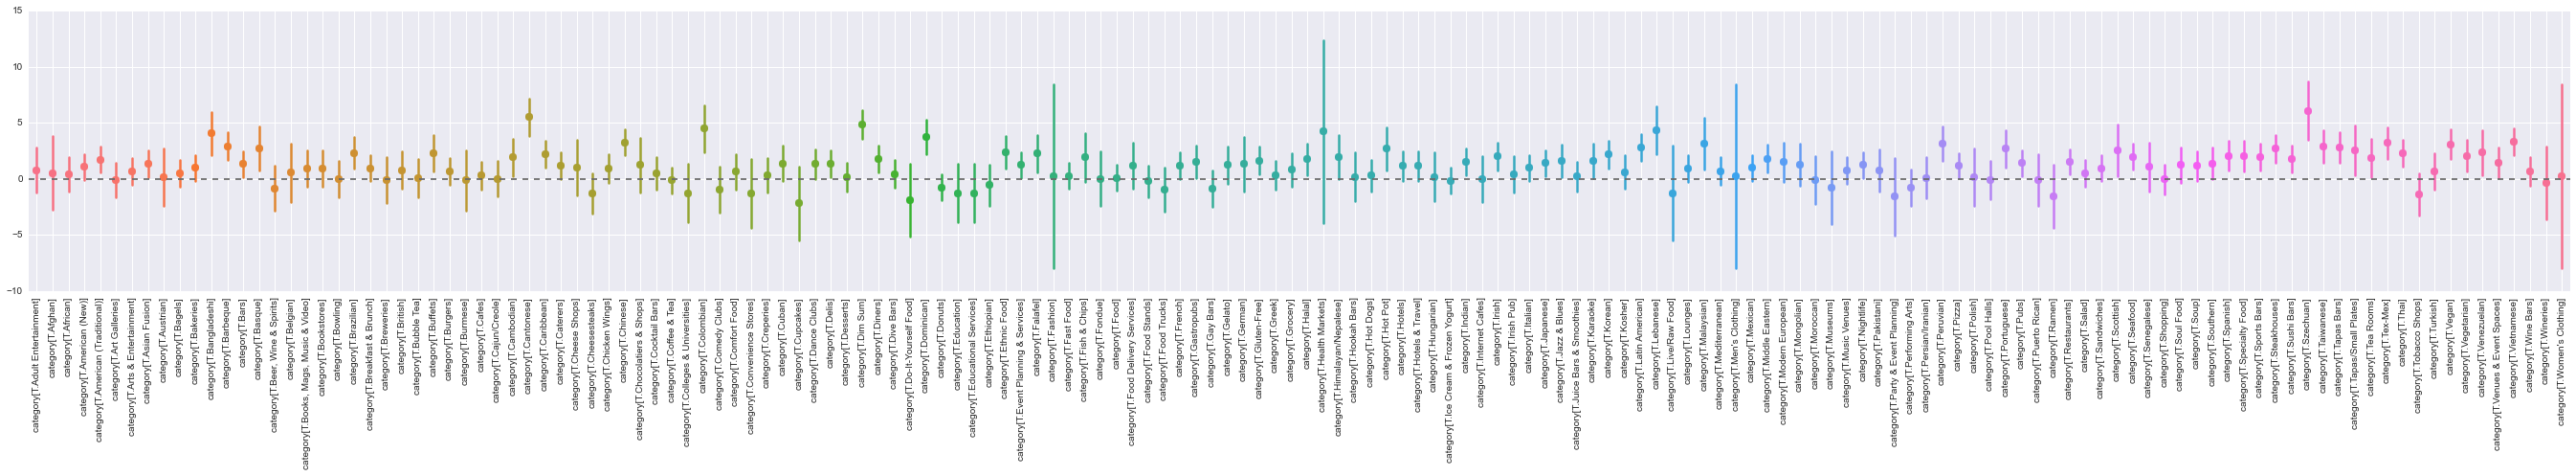

KeyboardInterrupt: 

In [18]:
cat = data[['restaurant_category_1',
 'restaurant_category_2',
 'restaurant_category_3',
 'restaurant_category_4',
 'restaurant_category_5',
 'restaurant_category_6',
 'restaurant_category_7','score_lvl_1','score_lvl_2','score_lvl_3']]
new = cat[['restaurant_category_1','score_lvl_1','score_lvl_2','score_lvl_3']]
new.columns = ['category', 'score_lvl_1','score_lvl_2','score_lvl_3']
for i in range(2,8):
    temp = cat[['restaurant_category_'+str(i),'score_lvl_1','score_lvl_2','score_lvl_3']]
    temp.columns = ['category', 'score_lvl_1','score_lvl_2','score_lvl_3']
    new = new.append(temp)
    
sns.mpl.rc("figure", figsize=(30,14))
scores = ['score_lvl_1','score_lvl_2','score_lvl_3']
for score in scores:
    formula = score + " ~ " + 'category'
    print("\n* Formula: {}".format(formula))

    # seaborn can't handle categorical data type so have to convert_objects first
    g = sns.coefplot(formula, new.dropna().convert_objects())
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('visuals/restaurant_type_coefficients_' + score)
sns.mpl.rc("figure", figsize=(14,10))

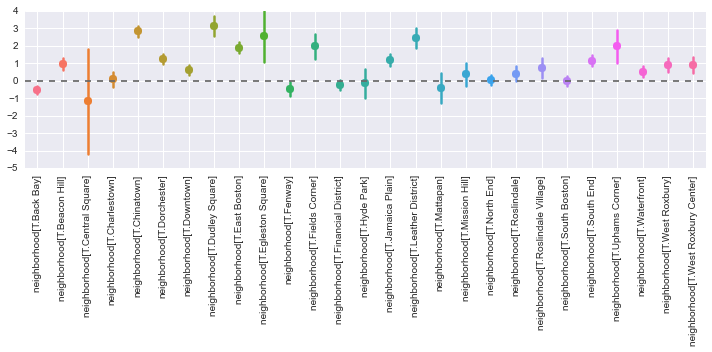

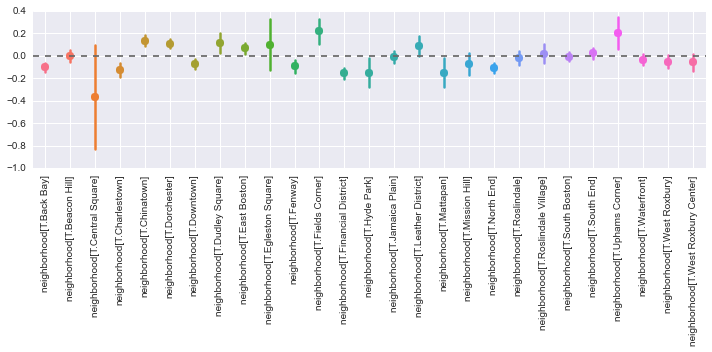

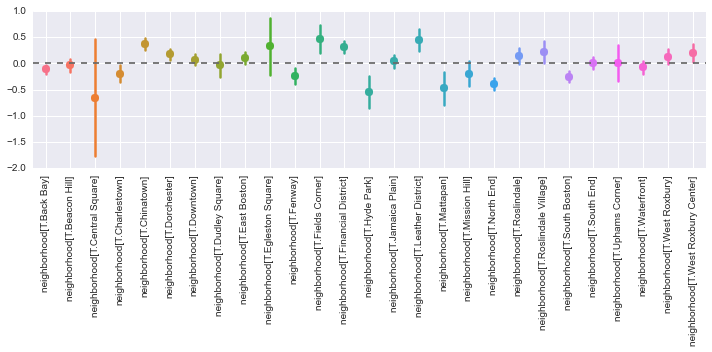

In [14]:
neigh = data[['restaurant_neighborhood_1',
 'restaurant_neighborhood_2',
 'restaurant_neighborhood_3','score_lvl_1','score_lvl_2','score_lvl_3']]
new = neigh[['restaurant_neighborhood_1','score_lvl_1','score_lvl_2','score_lvl_3']]
new.columns = ['neighborhood','score_lvl_1','score_lvl_2','score_lvl_3']
for i in range(2,3):
    temp = neigh[['restaurant_neighborhood_'+str(i),'score_lvl_1','score_lvl_2','score_lvl_3']]
    temp.columns = ['neighborhood','score_lvl_1','score_lvl_2','score_lvl_3']
    new = new.append(temp)
    
sns.mpl.rc("figure", figsize=(8,10))
scores = ['score_lvl_1','score_lvl_2','score_lvl_3']
for score in scores:
    formula = score + " ~ " + 'neighborhood'
    print("\n* Formula: {}".format(formula))

    # seaborn can't handle categorical data type so have to convert_objects first
    g = sns.coefplot(formula, new.dropna().convert_objects())
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('visuals/restaurant_neighborhood_coefficients_' + score)
sns.mpl.rc("figure", figsize=(14,10))


* Formula: score_lvl_1 ~ C(restaurant_stars) + restaurant_review_count + checkin_counts

* Formula: score_lvl_2 ~ C(restaurant_stars) + restaurant_review_count + checkin_counts

* Formula: score_lvl_3 ~ C(restaurant_stars) + restaurant_review_count + checkin_counts


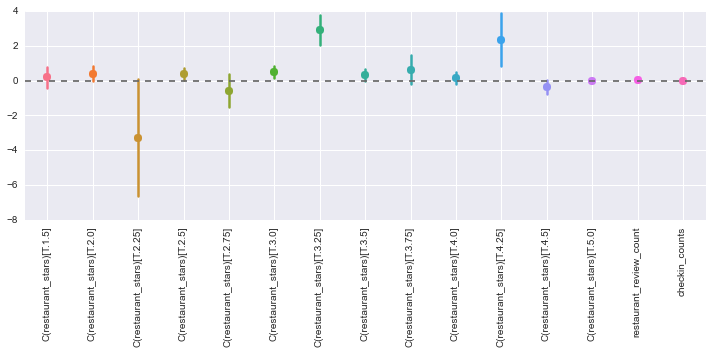

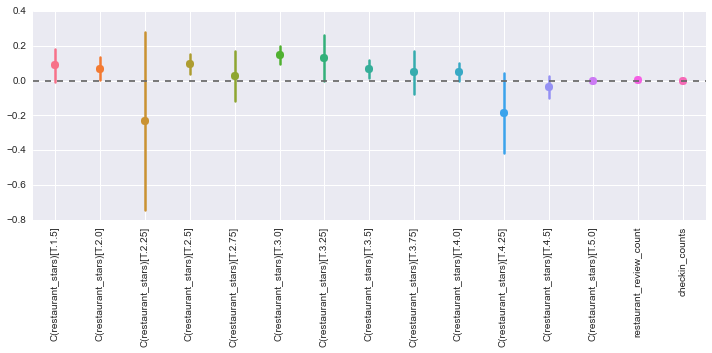

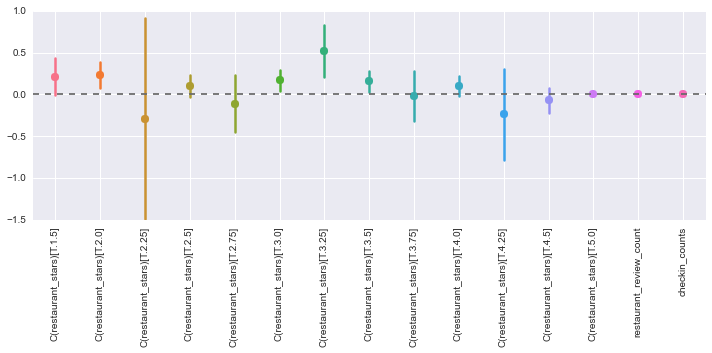

In [11]:
feature_list = ['restaurant_stars', 'restaurant_review_count', 'checkin_counts']

review_attributes = X[feature_list]

sns.mpl.rc("figure", figsize=(8,10))
# X_formula = " * ".join([i for i in selects.columns.tolist()])
X_formula = " + ".join([i for i in review_attributes.columns.tolist()])

scores = ['score_lvl_1', 'score_lvl_2', 'score_lvl_3']
for score in scores:
#     formula = score + " ~ " + X_formula
    formula = score + " ~ C(restaurant_stars) + restaurant_review_count + checkin_counts"
    print("\n* Formula: {}".format(formula))

    # seaborn can't handle categorical data type so have to convert_objects first
    g = sns.coefplot(formula, data.convert_objects(), intercept=False)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('visuals/review_attributes_coefficients_' + score)

sns.mpl.rc("figure", figsize=(14,10))

In [51]:
for score in scores:
    sns.stripplot(X['restaurant_stars'], y[score], jitter=True)
    plt.tight_layout()
    plt.savefig('visuals/restaurant_stars_stripplot' + score)
    plt.close()

In [50]:
for score in scores:
    g = sns.stripplot(X['restaurant_stars'], y[score], hue=X['restaurant_ambience'])
    plt.tight_layout()
    plt.savefig('visuals/restaurant_stars_by_restaurant_ambience_stripplot' + score)


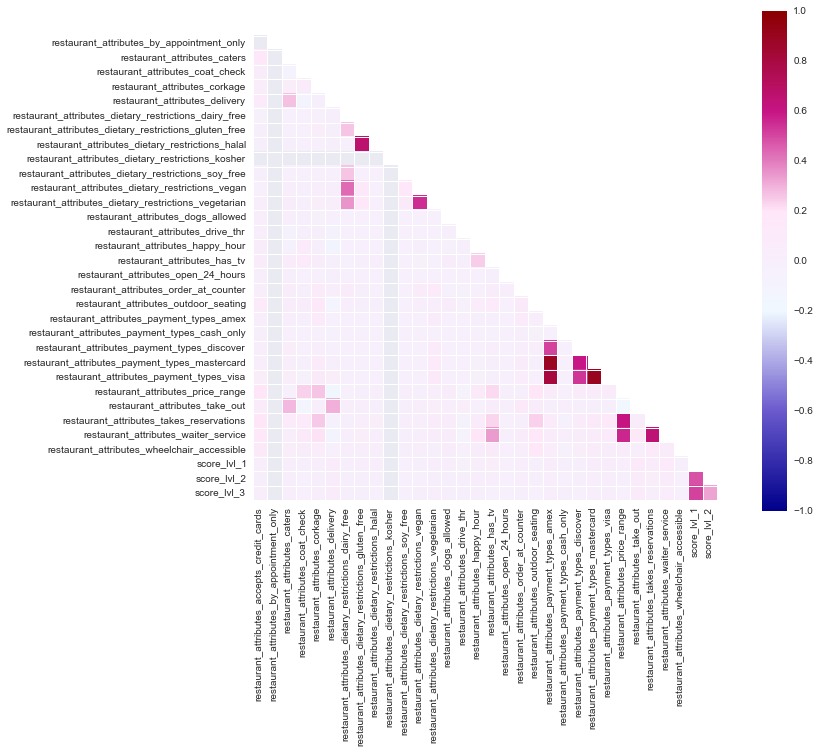

In [22]:
f, ax = plt.subplots(figsize=(12,12))
cmap = sns.blend_palette(["#00008B", "#6A5ACD", "#F0F8FF",
                          "#FFE6F8", "#C71585", "#8B0000"], as_cmap=True)
sns.corrplot(pd.concat([atts, y], axis=1), annot=False, diag_names=False, cmap=cmap)
ax.grid(False)
plt.tight_layout()
plt.savefig('visuals/corr_plot')


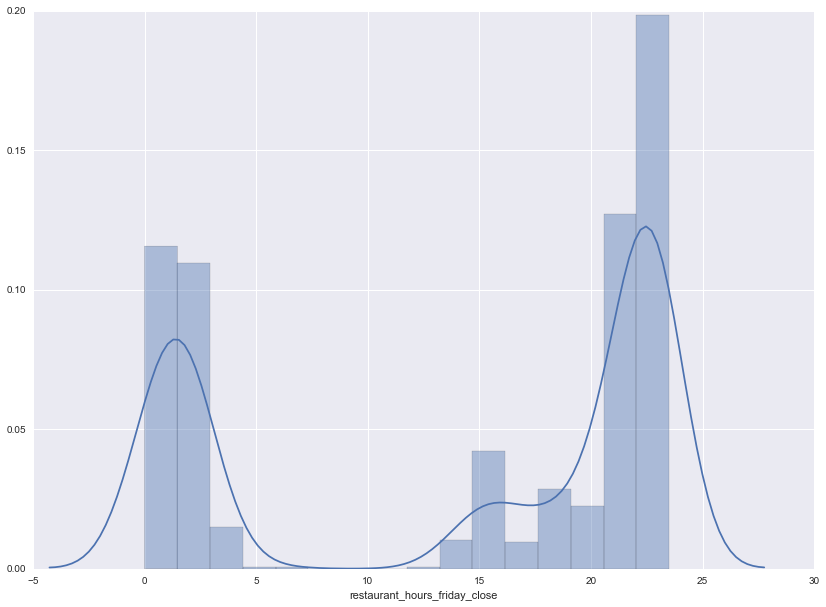

In [167]:
sns.distplot(X.restaurant_hours_friday_close.dropna())

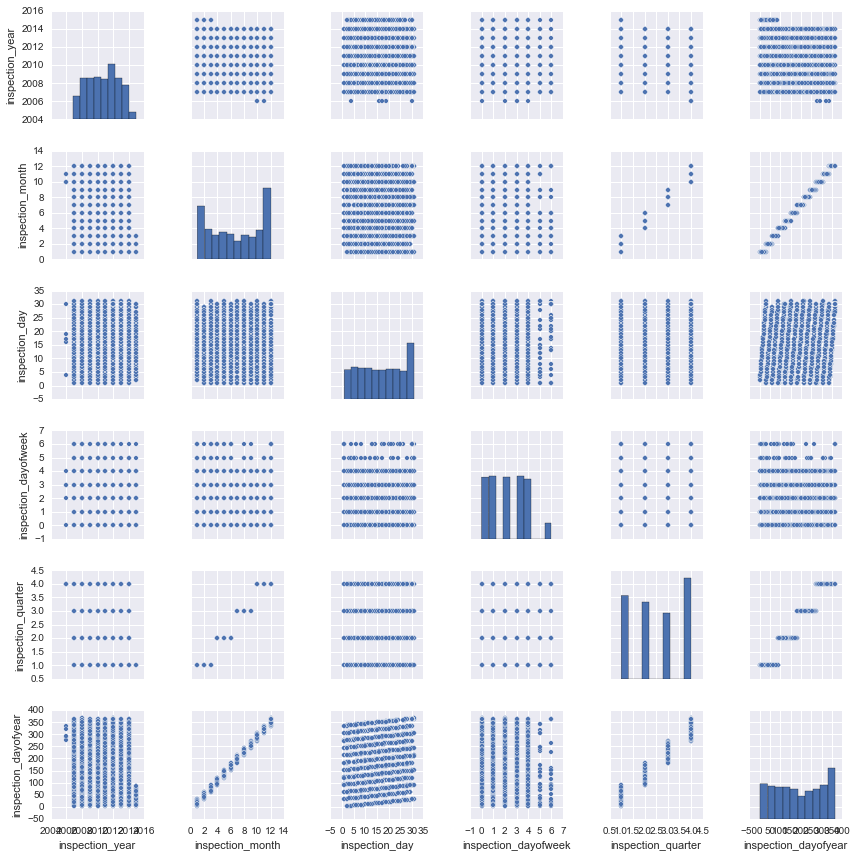

In [32]:
features =[ 'inspection_year',
 'inspection_month',
 'inspection_day',
 'inspection_dayofweek',
 'inspection_quarter',
 'inspection_dayofyear']

sns.pairplot(X[features], size=2)
plt.tight_layout()
plt.savefig('visuals/multi_plot')

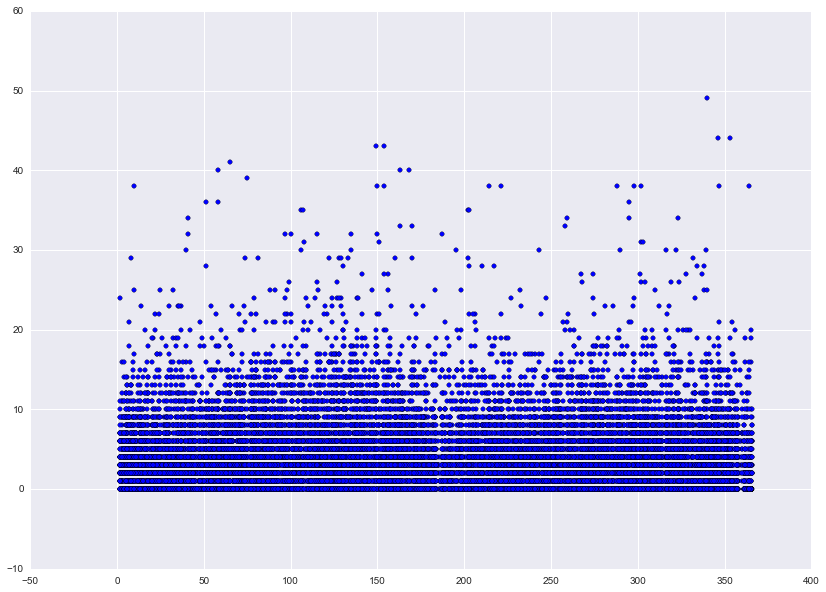

In [166]:
plt.scatter(data['inspection_dayofyear'], data['score_lvl_1'])

In [12]:
scores = ['score_lvl_1', 'score_lvl_2', 'score_lvl_3']
model_features = [
'restaurant_attributes_accepts_credit_cards',
'restaurant_attributes_byob',
'restaurant_attributes_by_appointment_only',
'restaurant_attributes_caters',
'restaurant_attributes_coat_check',
'restaurant_attributes_corkage',
'restaurant_attributes_delivery',
'restaurant_attributes_dietary_restrictions_dairy_free',
'restaurant_attributes_dietary_restrictions_gluten_free',
'restaurant_attributes_dietary_restrictions_halal',
'restaurant_attributes_dietary_restrictions_kosher',
'restaurant_attributes_dietary_restrictions_soy_free',
'restaurant_attributes_dietary_restrictions_vegan',
'restaurant_attributes_dietary_restrictions_vegetarian',
'restaurant_attributes_dogs_allowed',
'restaurant_attributes_drive_thr',
'restaurant_attributes_good_for_dancing',
'restaurant_attributes_good_for_groups',
'restaurant_attributes_good_for_breakfast',
'restaurant_attributes_good_for_brunch',
'restaurant_attributes_good_for_dessert',
'restaurant_attributes_good_for_dinner',
'restaurant_attributes_good_for_latenight',
'restaurant_attributes_good_for_lunch',
'restaurant_attributes_good_for_kids',
'restaurant_attributes_happy_hour',
'restaurant_attributes_has_tv',
'restaurant_attributes_open_24_hours',
'restaurant_attributes_order_at_counter',
'restaurant_attributes_outdoor_seating',
'restaurant_attributes_payment_types_amex',
'restaurant_attributes_payment_types_cash_only',
'restaurant_attributes_payment_types_discover',
'restaurant_attributes_payment_types_mastercard',
'restaurant_attributes_payment_types_visa',
'restaurant_attributes_take_out',
'restaurant_attributes_takes_reservations',
'restaurant_attributes_waiter_service',
'restaurant_attributes_wheelchair_accessible',
]
X, y = extract_features(train_df[model_features + scores])
# X, y = extract_features(pd.get_dummies(new, columns=['category']))
# X, y = extract_features(new)

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

# set classifiers to test
# estimator = LinearRegression()
# estimator = RandomForestClassifier(n_jobs=-1)
estimator = SGDClassifier(n_jobs=-1)

# can use with text if convert X to dense with .toarray() but is super heavy on ram
pipeline = Pipeline([
        ('scaler', Normalizer()),
#         ('scaler', StandardScaler()),
#         ('scaler', StandardScaler(with_mean=False)), #  for sparse matrix
        ('clf', estimator),
])

for score in scores:
    print(score)
    score_model(X, y[score], pipeline)

print
contest_scoring(X, y, pipeline)

1.8287466210474064

In [36]:
from nltk.corpus import wordnet as wn
from textblob import Word

def is_noun(tag):
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']


def is_verb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']


def is_adverb(tag):
    return tag in ['RB', 'RBR', 'RBS']


def is_adjective(tag):
    return tag in ['JJ', 'JJR', 'JJS']


def penn_to_wn(tag):
    if is_adjective(tag):
        return wn.ADJ
    elif is_noun(tag):
        return wn.NOUN
    elif is_adverb(tag):
        return wn.ADV
    elif is_verb(tag):
        return wn.VERB
    return None


def preprocess(text):
    b = TextBlob(unicode(text, 'utf8').strip())
    tags = b.tags
#     tokens = []
#     for tagged in tags:
#         word = Word(tagged[0])
#         if word.isalpha() and word not in stopwords:
#             tag = penn_to_wn(tagged[1])
#             l = word.lemmatize(tag)
#             tokens.append(l.lower())
    tokens = map(preprocess2, tags)
    return ' '.join(filter(None, tokens))


def sentiments(text):
    b = TextBlob(unicode(text, 'utf8').strip())
    sentiment = lambda x: tuple(x.sentiment)
    return map(sentiment, b.sentences)

def preprocess2(tagged):
    word = Word(tagged[0])
    if word.isalpha() and word not in stopwords:
        tag = penn_to_wn(tagged[1])
        l = word.lemmatize(tag)
    else:
        l = ''
    return l.lower()


In [59]:
df = pd.read_pickle('pickle_jar/review_text_sentiment_for_all_reviews_df')

In [60]:
df['polarity'] = df.sentiment.apply(lambda x: x[0])
df['subjectivity'] = df.sentiment.apply(lambda x: x[1])

In [65]:
y.score_lvl_1.shape

(27088,)

In [19]:
from sklearn.externals import joblib

tfidf = joblib.load('pickle_jar/tfidf_preprocessed_ngram3_sublinear')

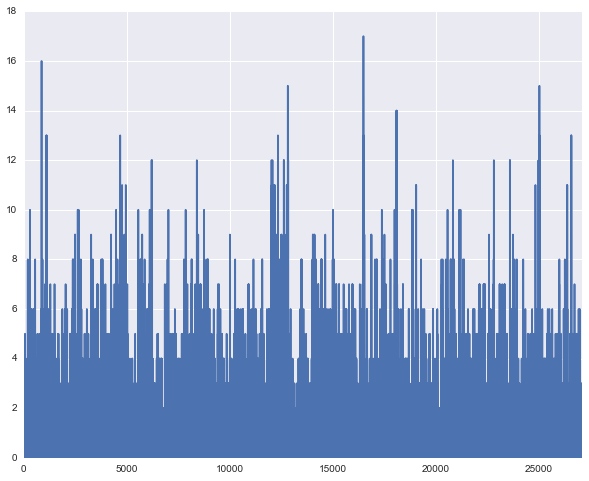

In [109]:
single = train_df[train_df.restaurant_id == '0ZEDGWOD'][['inspection_date', 'score_lvl_1', 'score_lvl_2', 'score_lvl_3']].sort('inspection_date')
sns.tsplot(train_df.set_index('inspection_date')['score_lvl_3'])

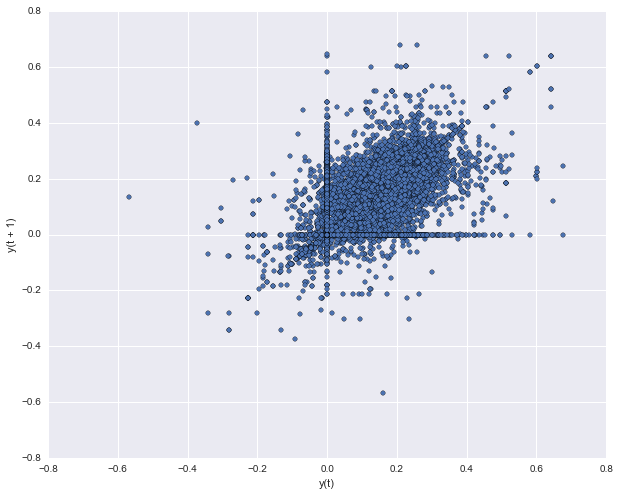

In [124]:
from pandas.tools.plotting import lag_plot
lag_plot(df[['polarity']])

In [15]:
train_df.previous_inspection_delta = train_df.previous_inspection_delta.fillna(0)
train_df.previous_inspection_delta = train_df.previous_inspection_delta.dt.days

In [17]:
scores = ['score_lvl_1', 'score_lvl_2', 'score_lvl_3']
model_features = ['previous_inspection_delta', 'restaurant_stars']
X, y = extract_features(train_df[model_features + scores])
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier


# set classifiers to test
# estimator = LinearRegression()
estimator = RandomForestClassifier(n_jobs=-1, random_state=42)
# estimator = SGDClassifier(n_jobs=-1, random_state=42)
# estimator = BaggingClassifier(random_state=42)

# can use with text if convert X to dense with .toarray() but is super heavy on ram
pipeline = Pipeline([
        ('normalizer', Normalizer()),
        ('scaler', StandardScaler()),
        ('clf', estimator),
])

for score in scores:
    print(score)
    score_model(X, y[score], pipeline)

print
contest_scoring(X, y, pipeline)

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s finished


score_lvl_1
CV score of 0.178942342375 +/- 0.00531610750913

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s finished



score_lvl_2
CV score of 0.691450255015 +/- 0.00218537885064

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s finished



score_lvl_3
CV score of 0.521485472685 +/- 0.000220360517513

Contest score of 1.58275545187


1.5827554518700739

In [250]:
model.similarity('violation', 'gross')

0.216147153912575

In [7]:
import word2vec_trainer
new_model = word2vec_trainer.vectorized_docs()

In [12]:
from gensim.models import Word2Vec
g_model = Word2Vec.load_word2vec_format('w2v data/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [38]:
new_model.most_similar('contaminate')

[(u'tongs', 0.18600264191627502),
 (u'pave', 0.17530634999275208),
 (u'rather', 0.17216037213802338),
 (u'dim', 0.1697315275669098),
 (u'seafoody', 0.16623201966285706),
 (u'go...i', 0.16352567076683044),
 (u'joyous', 0.16210609674453735),
 (u'shopping', 0.1597777009010315),
 (u'them...but', 0.15845456719398499),
 (u'evident', 0.15714827179908752)]

In [41]:
model.most_similar('contaminate')

KeyError: "word 'contaminate' not in vocabulary"

In [68]:
g_model.most_similar('toilet')

[(u'toilets', 0.7494617104530334),
 (u'lavatory', 0.7490381002426147),
 (u'bathroom', 0.6814741492271423),
 (u'loo', 0.6644749641418457),
 (u'toliet', 0.6513392925262451),
 (u'commode', 0.6438657641410828),
 (u'lavatories', 0.6319250464439392),
 (u'Toilet', 0.6273224353790283),
 (u'urinal', 0.6244111061096191),
 (u'restroom', 0.6035417914390564)]

In [11]:
df = pd.read_pickle('pickle_jar/preprocessed_review_text_df')

In [47]:
def get_similarities(words, topic):
    try:
        return g_model.similarity(topic, words)
    except:
        pass

def similarity_vector(text):
    similarities = []
    b = TextBlob(text)
    global topic
#     sim_vec = map(lambda text: get_similarities(text, topic), b.words)
    for word in b.words:
        try:
            similarities.append(g_model.similarity(topic, word))
        except:
            pass
    sim_vec = np.array(sorted(similarities, reverse=True)[:100], dtype='float32')
    backfill = lambda x: np.append(x, np.zeros((100 - len(x),)))
    return backfill(sim_vec)
    

In [80]:
from multiprocessing import Pool

def similarity_vector(text):
    similarities = []
    b = TextBlob(text)
#     sim_vec = map(lambda text: get_similarities(text, topic), b.words)
    for word in b.words:
        try:
            similarities.append(g_model.similarity(topic, word))
        except:
            pass
    sim_vec = np.array(sorted(similarities, reverse=True)[:100], dtype='float32')
    backfill = lambda x: np.append(x, np.zeros((100 - len(x),)))
    return backfill(sim_vec) if len(sim_vec) > 0 else ''

def pooling(df):
    topic_list = ['manager', 'supervisor']
    df = df.iloc[0:20]
    for i in topic_list:
        global topic
        topic = i
        pool = Pool()
        df[topic] = pool.map(similarity_vector, df.preprocessed_review_text.iloc[0:20])
        pool.close()
        pool.join()
    return df

In [154]:
flat = pd.read_pickle('pickle_jar/flat_train_df.pkl')

In [155]:
flat = flat[['inspection_year', 'restaurant_neighborhood_1', 'restaurant_neighborhood_2', 'restaurant_neighborhood_3', 'score_lvl_1', 'score_lvl_2', 'score_lvl_3',]]

In [156]:
flat.restaurant_neighborhood_1 = flat.restaurant_neighborhood_1.astype(str)
flat.restaurant_neighborhood_2 = flat.restaurant_neighborhood_2.astype(str)
flat.restaurant_neighborhood_3 = flat.restaurant_neighborhood_3.astype(str)

In [157]:
frn2 = flat[flat.restaurant_neighborhood_2 != 'nan']
frn3 = flat[flat.restaurant_neighborhood_3 != 'nan']
flat.drop(['restaurant_neighborhood_2', 'restaurant_neighborhood_3'], axis=1, inplace=True)
frn2.drop(['restaurant_neighborhood_1', 'restaurant_neighborhood_3'], axis=1, inplace=True)
frn3.drop(['restaurant_neighborhood_1', 'restaurant_neighborhood_2'], axis=1, inplace=True)

/Users/amangum/anaconda/envs/datasci/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/amangum/anaconda/envs/datasci/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [158]:
flat.rename(columns={'restaurant_neighborhood_1':'restaurant_neighborhood'}, inplace=True)
frn2.rename(columns={'restaurant_neighborhood_2':'restaurant_neighborhood'}, inplace=True)
frn3.rename(columns={'restaurant_neighborhood_3':'restaurant_neighborhood'}, inplace=True)

In [159]:
flat.restaurant_neighborhood.replace('nan', np.nan, inplace=True)

In [160]:
flat = pd.concat([flat, frn2, frn3])

In [161]:
flat.dropna(subset=['restaurant_neighborhood'], inplace=True)

In [162]:
flat.shape

(23055, 5)

In [163]:
flat.restaurant_neighborhood.replace('Allston/Brighton', 'Brighton', inplace=True)

In [164]:
flat = pd.concat([flat, flat[flat.restaurant_neighborhood == 'Brighton'].replace('Brighton', 'Allston')])

In [165]:
flat.restaurant_neighborhood.replace('Waterfront', 'South Boston Waterfront', inplace=True)

In [166]:
flat.restaurant_neighborhood.replace('Roslindale Village', 'Roslindale', inplace=True)

In [167]:
flat.restaurant_neighborhood.replace('West Roxbury Center', 'West Roxbury', inplace=True)

In [168]:
flat.restaurant_neighborhood.replace('Dudley Square', 'Roxbury', inplace=True)

In [169]:
flat.restaurant_neighborhood.replace('Fields Corner', 'Dorchester', inplace=True)

In [170]:
flat.restaurant_neighborhood.replace('Uphams Corner', 'Dorchester', inplace=True)

In [171]:
flat.restaurant_neighborhood.replace('Egleston Square', 'Roxbury', inplace=True)

In [172]:
flat.restaurant_neighborhood.replace('Central Square', 'East Boston', inplace=True)

In [179]:
flat.restaurant_neighborhood.replace('Financial District', 'Downtown', inplace=True)

In [173]:
flat = pd.concat([flat, flat[flat.restaurant_neighborhood == 'Mission Hill'].replace('Mission Hill', 'Longwood Medical Area')])

In [187]:
flat = flat[flat.inspection_year != 2006]

In [180]:
flat.restaurant_neighborhood.value_counts()

Back Bay                   3359
Downtown                   3014
Dorchester                 1924
South Boston               1897
North End                  1477
Brighton                   1412
Allston                    1412
South End                  1311
East Boston                1170
Chinatown                  1089
South Boston Waterfront    1042
West Roxbury                957
Jamaica Plain               957
Beacon Hill                 874
Roslindale                  719
Fenway                      565
Charlestown                 470
Roxbury                     234
Leather District            219
Mission Hill                175
Longwood Medical Area       175
Hyde Park                    97
Mattapan                     93
dtype: int64

In [304]:
g = flat.groupby(['restaurant_neighborhood', 'inspection_year']).mean()

In [305]:
g.reset_index(inplace=True)

In [306]:
g.columns = ['neighborhood', 'year', 'level_1', 'level_2', 'level_3']

In [314]:
# g.set_index(['neighborhood', 'year'], inplace=True)
g['location'] = g.apply(lambda x: x.neighborhood + ' ' + str(x.year), axis=1)

In [316]:
g.drop(['neighborhood', 'year'], axis=1, inplace=True)
g.set_index('location', inplace=True)

In [319]:
g.to_json('d3_data.json', orient='index')